In [1]:
import osmnx as ox, networkx as nx, pandas as pd, geopandas as gpd, time, matplotlib.pyplot as plt, math, ast, re
import matplotlib.cm as cm
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon
import statsmodels.api as sm, numpy as np
from geopy.distance import great_circle
from shapely.geometry import Polygon
%matplotlib inline
ox.config(use_cache=True, log_file=True, log_console=True, log_filename='analyze_stats_every_us_urban_area',
          data_folder='G:/Geoff/osmnx/urbanized-areas-usa', cache_folder='G:/Geoff/osmnx/cache')

In [2]:
df = pd.read_csv('usa_stats.csv', encoding='utf-8')
len(df)

497

In [3]:
df['city'] = df['name'].map(lambda x: re.findall(r'^[a-z A-Z\s\.]*', x)[0])

In [4]:
df['streets_per_node_proportion'] = [ast.literal_eval(p) for p in df['streets_per_node_proportion']]

## Plot distribution of intersection types for 9 cities

In [5]:
names = ['Detroit', 'Lubbock', 'Chattanooga', 'Duluth', 'New Orleans', 'Phoenix',
         'Boston', 'Atlanta', 'Chicago']
stats_plot = df[df['city'].isin(names)]
stats_plot = stats_plot.sort_values('area', ascending=False)
stats_plot['city']

1          Atlanta
2          Chicago
4           Boston
8          Detroit
11         Phoenix
67     Chattanooga
80     New Orleans
188        Lubbock
256         Duluth
Name: city, dtype: object

In [6]:
proportion_streets_per_intersection = stats_plot['streets_per_node_proportion'].tolist()
names_full = stats_plot['name'].tolist()
names = [re.findall(r'^[a-zA-Z\s]*', name)[0] for name in names_full]

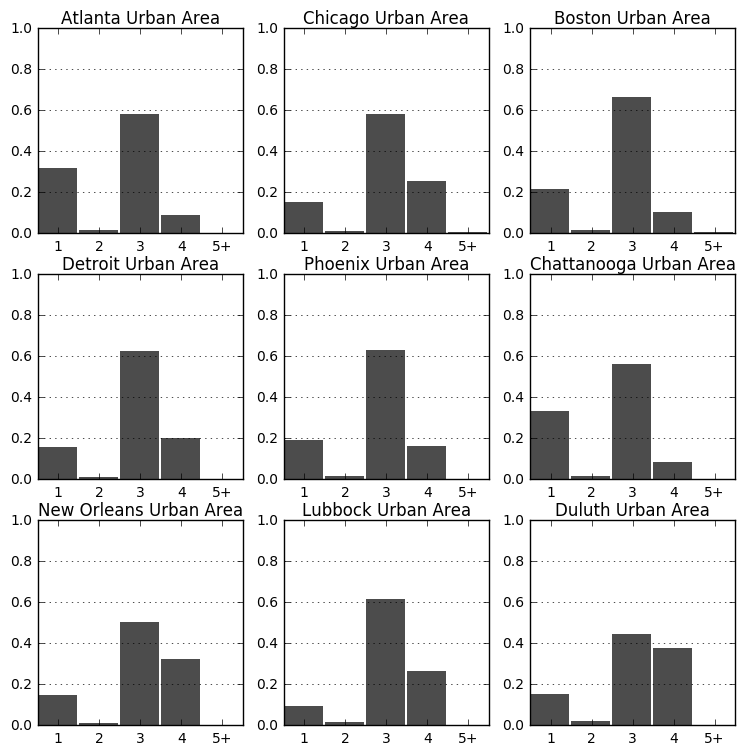

In [7]:
n = len(proportion_streets_per_intersection)
cols = 3
rows = int(n / cols)
max_value = 4
fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
for i, (prop, name) in enumerate(zip(proportion_streets_per_intersection, names)):
    
    row = math.floor(i / cols)
    col = i % cols
    ax = axes[row][col]
    
    all_others = sum(list(prop.values())[max_value + 1:])
    prop = {key:value for key, value in prop.items() if key <= max_value}
    prop[max_value + 1] = all_others
    lefts = [x - 0.5 for x in prop.keys()]
    
    ax.bar(left=lefts, height=prop.values(), width=0.95, alpha=0.7,
           color='k', linewidth=0)
    ax.yaxis.grid(True)
    xticklabels = list(range(0, max_value + 1)) + ['{}+'.format(max_value + 1)]
    ax.set_xticklabels(xticklabels)
    
    ax.set_title('{} Urban Area'.format(name), fontsize=12, y=0.99)
    ax.set_xlim(0.5, max_value + 1.5)
    ax.set_ylim(0, 1)

In [8]:
# which cities have high proportion of cul-de-sacs
prop = df['streets_per_node_proportion'].tolist()
df.loc[pd.DataFrame(prop, index=df.index).sort_values(1, ascending=False).head(20).index]['name']

87     Aguadilla--Isabela--San Sebastián, PR Urbanize...
191    San Germán--Cabo Rojo--Sabana Grande, PR Urban...
219                           Arecibo, PR Urbanized Area
357      Florida--Imbéry--Barceloneta, PR Urbanized Area
367                           Midland, MI Urbanized Area
17                           San Juan, PR Urbanized Area
313                          Mayagüez, PR Urbanized Area
343                        Juana Díaz, PR Urbanized Area
236                     Santa Clarita, CA Urbanized Area
297           Westminster--Eldersburg, MD Urbanized Area
354                             Yauco, PR Urbanized Area
335    Lexington Park--California--Chesapeake Ranch E...
226                        Marysville, WA Urbanized Area
398    Kailua (Honolulu County)--Kaneohe, HI Urbanize...
67                    Chattanooga, TN--GA Urbanized Area
143                         Bremerton, WA Urbanized Area
259                         Los Lunas, NM Urbanized Area
96                            C

In [9]:
df.sort_values(by='circuity_avg', ascending=True).head()

,area,area_km,avg_neighbor_degree_avg,avg_weighted_neighbor_degree_avg,circuity_avg,clustering_coefficient_avg,clustering_coefficient_weighted_avg,count_intersections,degree_centrality_avg,edge_density_km,...,self_loop_proportion,street_density_km,street_length_avg,street_length_total,street_segments_count,streets_per_node_avg,streets_per_node_counts,streets_per_node_proportion,time,city
318,137141203,137.141203,3.236835,0.030722,1.023909,0.022868,0.001015,5547,0.000972,19810.535721,...,0.000636,10548.638904,148.588027,1.446653e+06,9736,3.123596,"{0: 9, 1: 674, 2: 134, 3: 3147, 4: 2254, 5: 11...","{0: 0.0014446227929373998, 1: 0.10818619582664...",4.873442,Midland
292,152630919,152.630919,3.238556,0.029850,1.026418,0.028539,0.002454,5531,0.001001,19062.158308,...,0.000749,9790.403435,157.828293,1.494318e+06,9468,3.096384,"{0: 18, 1: 562, 2: 212, 3: 3344, 4: 1971, 5: 4}","{0: 0.0029455081001472753, 1: 0.09196530846015...",4.418135,Odessa
188,249860381,249.860381,3.061863,0.039490,1.032750,0.030546,0.000951,16303,0.000321,24808.079054,...,0.001018,13515.915970,122.141557,3.377092e+06,27649,3.066652,"{0: 19, 1: 1697, 2: 318, 3: 11109, 4: 4804, 5:...","{0: 0.001054442532881958, 1: 0.094178367278983...",13.290417,Lubbock
228,210823472,210.823472,3.222593,0.037569,1.034604,0.024726,0.000363,12770,0.000443,24242.545885,...,0.001463,12876.212062,122.246588,2.714608e+06,22206,3.206246,"{0: 18, 1: 1045, 2: 257, 3: 7285, 4: 5205, 5: ...","{0: 0.0013012361743656475, 1: 0.07554398901178...",10.096168,Amarillo
283,160423274,160.423274,3.003879,0.129425,1.035577,0.038410,0.002402,2818,0.001559,11362.450516,...,0.002776,5833.523487,194.762318,9.358329e+05,4805,2.764926,"{0: 9, 1: 640, 2: 185, 3: 1962, 4: 665, 5: 6}","{0: 0.0025959042399769255, 1: 0.18459763484280...",2.641833,Vineland


In [10]:
# filter df for outliers in some column
#col = 'node_count'
stats_plot = df#[df[col] < 100000]
print('Threw out {} greatest {} outliers'.format(len(df)-len(stats_plot), col))

Threw out 0 greatest 2 outliers


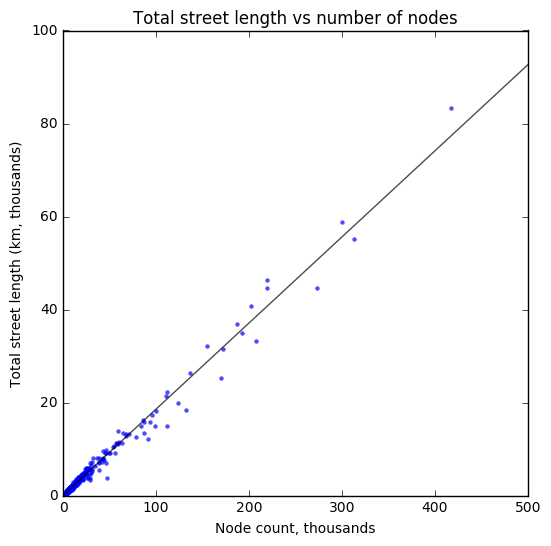

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
x = stats_plot['n'] / 1000
y = stats_plot['street_length_total'] / 1000 / 1000

xlim = [0, math.ceil(x.max()/100)*100] #round to nearest greater 100
ylim = [0, math.ceil(y.max()/20)*20] #round to nearest greater 20

# regress y on x
results = sm.OLS(y, sm.add_constant(x)).fit()

# calculate estimated y values for regression line
x_line = pd.Series(xlim)
y_est = x_line * results.params[1] + results.params[0]

# draw regression line and scatter plot the points
ax.plot(x_line, y_est, c='k', alpha=0.7, linewidth=1, zorder=1)
ax.scatter(x=x, y=y, c='b', linewidths=0, alpha=0.7, s=10)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
#ax.set_xlim((0,15000))
#ax.set_ylim((0,3000))

ax.set_title('Total street length vs number of nodes')
ax.set_xlabel('Node count, thousands')
ax.set_ylabel('Total street length (km, thousands)')

fig.savefig(filename='images/usa-ua-street-length-vs-nodes', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
print(results.rsquared)
results.params

0.984374579549


const    0.066976
n        0.185244
dtype: float64

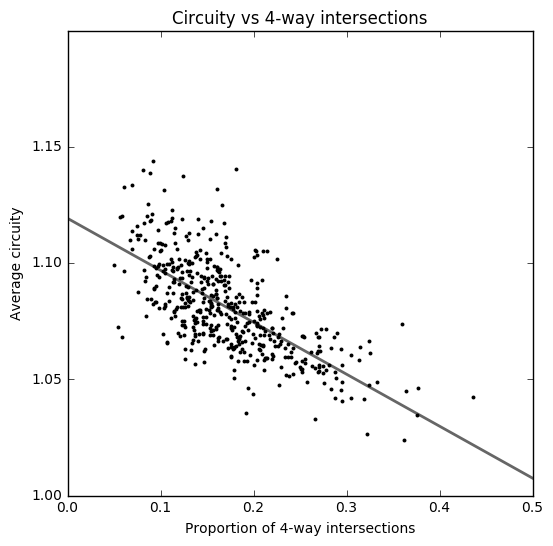

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
y = stats_plot['circuity_avg']
x = stats_plot['int_4_streets_prop']

ylim = (1,1.2)
xlim = (0,0.5)

# regress y on x
results = sm.OLS(y, sm.add_constant(x)).fit()

# calculate estimated y values for regression line
x_line = pd.Series(xlim)
y_est = x_line * results.params[1] + results.params[0]

# draw regression line and scatter plot the points
ax.plot(x_line, y_est, c='k', alpha=0.6, linewidth=2, zorder=-1)
ax.scatter(x=x, y=y, c='k', linewidths=0, alpha=1, s=8)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_title('Circuity vs 4-way intersections')
ax.set_ylabel('Average circuity')
ax.set_xlabel('Proportion of 4-way intersections')

fig.savefig(filename='images/usa-ua-circuity-vs-k4', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
print('r-squared:', results.rsquared)
results.params

r-squared: 0.465958310612


const                 1.119211
int_4_streets_prop   -0.223465
dtype: float64

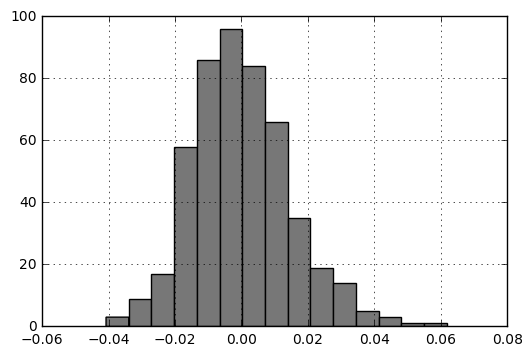

In [15]:
ax = results.resid.hist(bins=15, figsize=(6,4), fc='#777777', ec='k')

In [16]:
df.columns

Index(['area', 'area_km', 'avg_neighbor_degree_avg',
       'avg_weighted_neighbor_degree_avg', 'circuity_avg',
       'clustering_coefficient_avg', 'clustering_coefficient_weighted_avg',
       'count_intersections', 'degree_centrality_avg', 'edge_density_km',
       'edge_length_avg', 'edge_length_total', 'geoid', 'int_0_streets_count',
       'int_0_streets_prop', 'int_10_streets_count', 'int_10_streets_prop',
       'int_11_streets_count', 'int_11_streets_prop', 'int_12_streets_count',
       'int_12_streets_prop', 'int_13_streets_count', 'int_13_streets_prop',
       'int_14_streets_count', 'int_14_streets_prop', 'int_1_streets_count',
       'int_1_streets_prop', 'int_2_streets_count', 'int_2_streets_prop',
       'int_3_streets_count', 'int_3_streets_prop', 'int_4_streets_count',
       'int_4_streets_prop', 'int_5_streets_count', 'int_5_streets_prop',
       'int_6_streets_count', 'int_6_streets_prop', 'int_7_streets_count',
       'int_7_streets_prop', 'int_8_streets_count', '

In [17]:
cols = ['area_km', 'avg_neighbor_degree_avg',
       'avg_weighted_neighbor_degree_avg', 'circuity_avg',
       'clustering_coefficient_avg', 'clustering_coefficient_weighted_avg',
       'count_intersections', 'degree_centrality_avg', 'edge_density_km',
       'edge_length_avg', 'edge_length_total', 'geoid',
       'int_1_streets_prop', 'int_3_streets_prop', 'int_4_streets_prop', 'intersection_density_km',
       'k_avg', 'm', 'n', 'name', 'node_density_km', 'pagerank_max',
       'pagerank_min',
       'self_loop_proportion', 'street_density_km', 'street_length_avg',
       'street_length_total', 'street_segments_count', 'streets_per_node_avg', 'city']
summary = df[cols]

In [18]:
summary = summary.describe().T.drop(['count', '25%', '75%'], axis=1).applymap(lambda x: round(x, 3))

In [19]:
summary.to_csv('summary.csv', encoding='utf-8')

In [20]:
cols = ['area_km',
       'circuity_avg',
       'clustering_coefficient_avg',
       'int_1_streets_prop', 'int_3_streets_prop', 'int_4_streets_prop', 'intersection_density_km',
       'street_density_km', 'street_length_avg',
       'streets_per_node_avg', 'city']
largest_metros = df[cols].head(30).applymap(lambda x: round(x, 2) if isinstance(x, float) else x)

In [21]:
largest_metros.to_csv('largest_metros.csv', encoding='utf-8')

In [37]:
largest_metros.columns

Index(['area_km', 'circuity_avg', 'clustering_coefficient_avg',
       'int_1_streets_prop', 'int_3_streets_prop', 'int_4_streets_prop',
       'intersection_density_km', 'street_density_km', 'street_length_avg',
       'streets_per_node_avg', 'city'],
      dtype='object')

In [42]:
variable = 'street_length_avg'
largest_metros.sort_values(by=variable)[['city', variable]]

,city,street_length_avg
22,Baltimore,105.42
25,Denver,114.41
13,Seattle,115.15
7,Houston,116.46
9,Washington,120.08
6,Los Angeles,125.89
29,Milwaukee,127.55
17,San Juan,128.19
11,Phoenix,131.26
2,Chicago,132.67


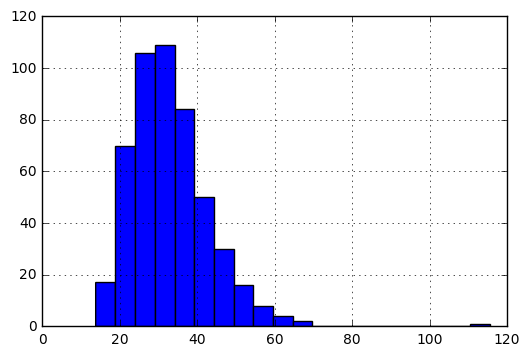

In [22]:
df['intersection_density_km'].hist(bins=20)

In [33]:
df[['name', 'street_length_avg']].sort_values(by='street_length_avg', ascending=False)

,name,street_length_avg
321,"East Stroudsburg, PA--NJ Urbanized Area",200.807395
151,"Danbury, CT--NY Urbanized Area",199.712673
230,"Dalton, GA Urbanized Area",198.951533
117,"Victorville--Hesperia, CA Urbanized Area",197.699210
237,"Hammond, LA Urbanized Area",196.038927
155,"Lake Charles, LA Urbanized Area",195.230248
283,"Vineland, NJ Urbanized Area",194.762318
76,"Hickory, NC Urbanized Area",190.439587
233,"Pottstown, PA Urbanized Area",189.135361
288,"Morristown, TN Urbanized Area",187.283314


## Map the urbanized areas by attribute

In [28]:
gdf = gpd.read_file('input_data/tl_2016_us_uac10')
df['geoid'] = df['geoid'].astype(str)
data = pd.merge(gdf, df, left_on='GEOID10', right_on='geoid')

In [29]:
variable = 'intersection_density_km'
data = data[['geometry', 'city', variable]].sort_values(by=variable)
color_list = [cm.get_cmap('plasma')(x) for x in np.linspace(0, 1, len(data))]

In [30]:
# project to ESRI's North America Lambert Conformal Conic 
#data = data.to_crs({'init': 'ESRI:102008'})

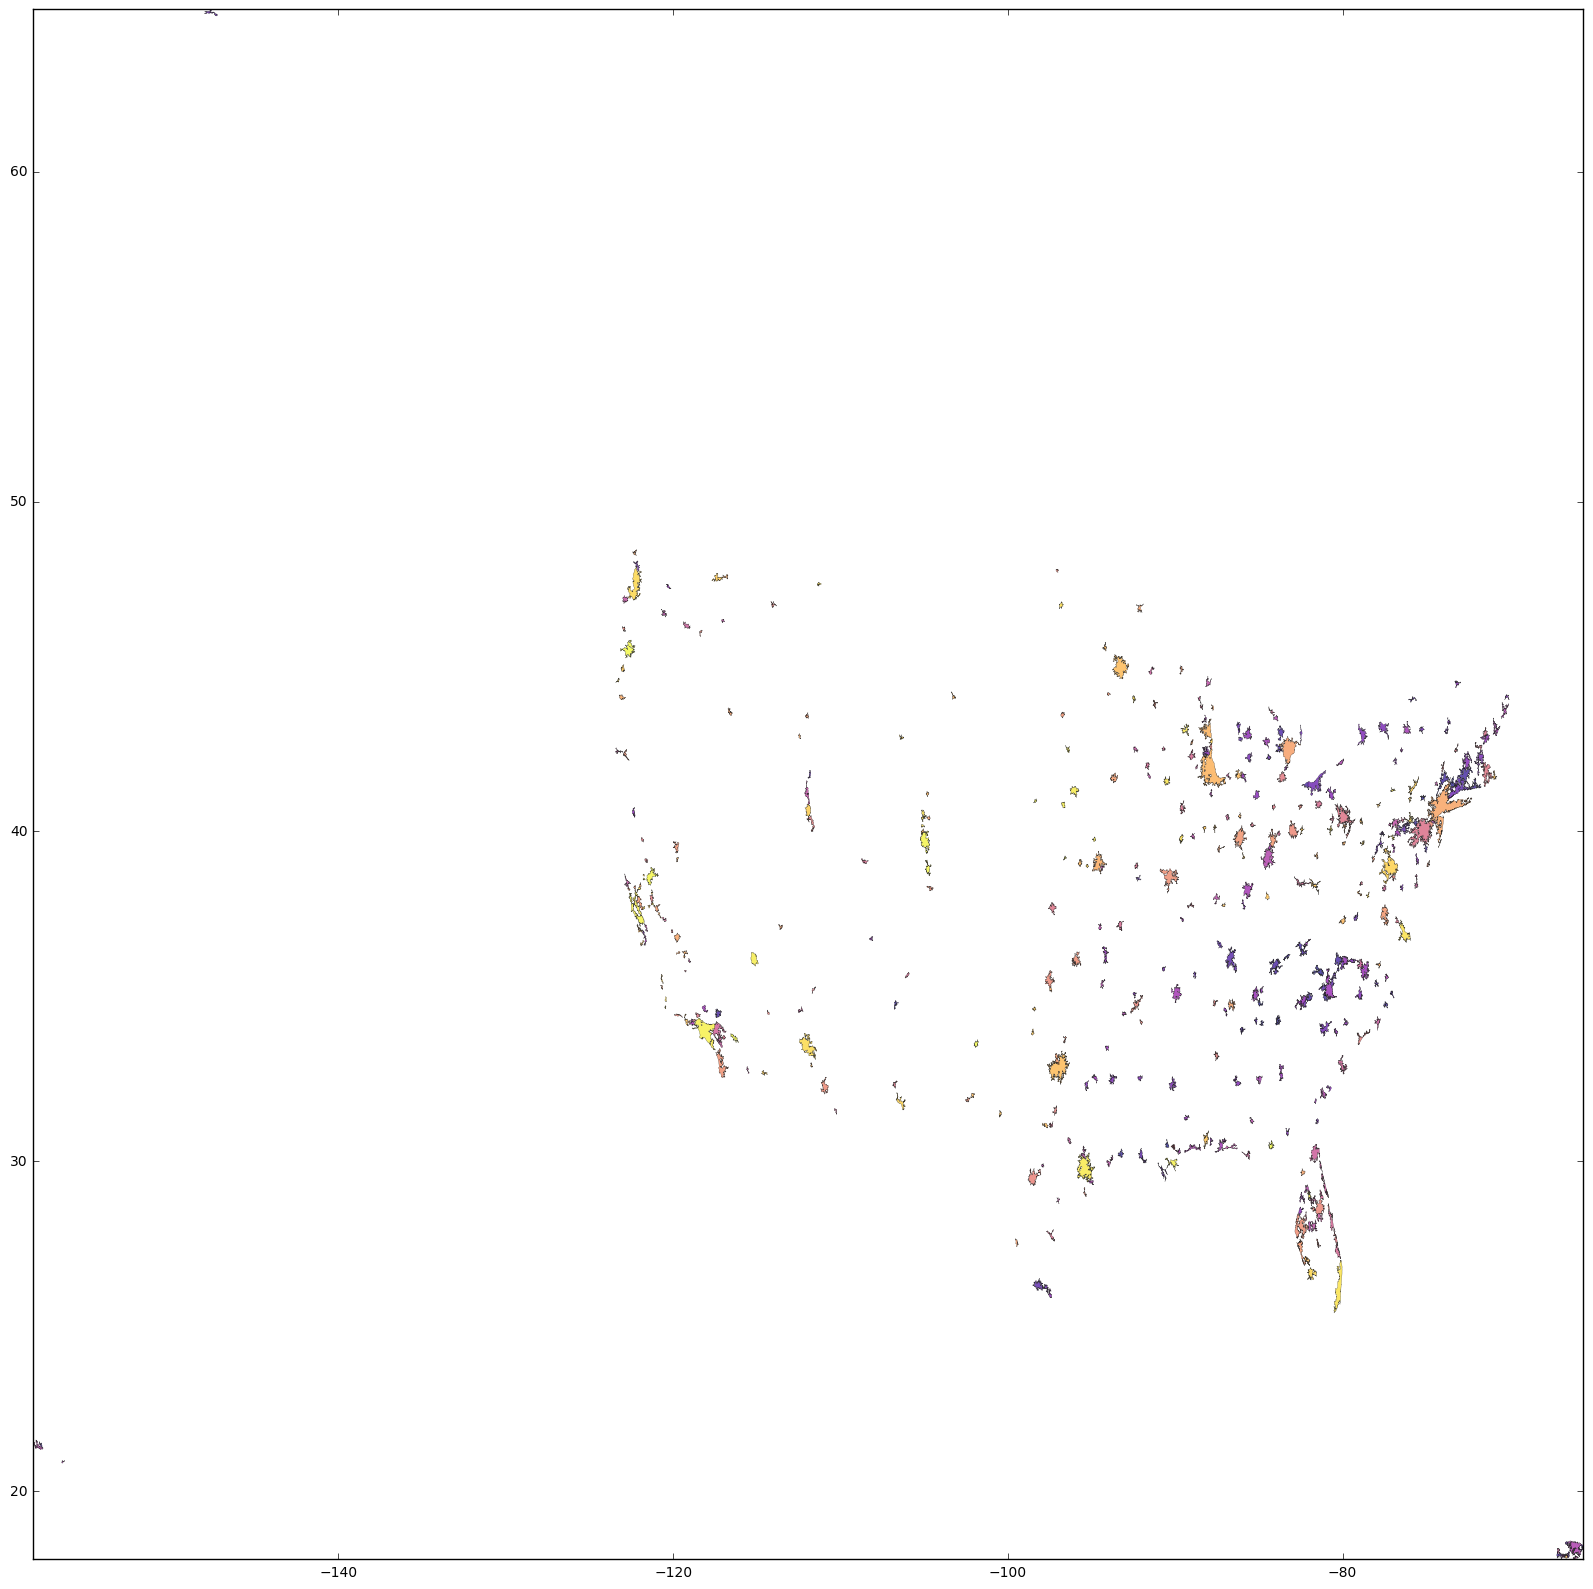

In [31]:
fig, ax = plt.subplots(figsize=(20,20))

# extract each polygon as a descartes patch, and add to a matplotlib patch collection...
patches = []
fc = []
for geometry, color in zip(data['geometry'], color_list):
    if isinstance(geometry, Polygon):
        patches.append(PolygonPatch(geometry))
        fc.append(color)
    elif isinstance(geometry, MultiPolygon):
        for subpolygon in geometry: #if geometry is multipolygon, go through each constituent subpolygon
            patches.append(PolygonPatch(subpolygon))
            fc.append(color)
pc = PatchCollection(patches, facecolor=fc, linewidth=0.2, alpha=0.7)
ax.add_collection(pc)

# set the figure bounds to the polygons' bounds
left, bottom, right, top = data.total_bounds
ax.set_xlim((left,right))
ax.set_ylim((bottom,top))
#ax.axis('off')
plt.show()